In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.metrics import classification_report,confusion_matrix,multilabel_confusion_matrix
import transformers
from PIL import Image
from efficientnet_pytorch import EfficientNet
from torchvision.io import read_image, ImageReadMode
import os
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

In [24]:
from mmar.custom.pylon.trainer.start import *
from mmar.custom.pylon.utils.pretrain import *
from mmar.custom.pylon.model.common import *
from mmar.custom.pylon.pylon import PylonConfig

In [6]:
# edit run number
run_number = "100"

model_path = "/workspace/nvflare/fl-nvflare/server/run_"+run_number+"/app_server/FL_global_model.pt"
data_path = "/workspace/nvflare/fl-nvflare/data/"

In [37]:
sites = ["c","n"]
# sites = ["c","n","p","v"]
col_list = ['Image', 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Pneumothorax', 'Edema']
labels_col = col_list[1:]
n_labels = len(labels_col)
image_w = 256
image_h = 256

In [29]:
# Testing dataset is from all sites
test_all = pd.DataFrame(columns=col_list)

for site in sites:
    site_path = data_path+"data_"+site+"/"
    image_path = "data_"+site+"/images/"
    
    test = pd.read_csv(site_path+"test_"+site+".csv")
    test['Image'] = test['Image'].apply(lambda x: image_path+x)
    test_all = pd.concat([test_all,test],axis=0)

test_all = test_all.sample(frac=1).reset_index(drop=True)

In [ ]:
def dicom2array(path, voi_lut=True, fix_monochrome=True):
    """Convert DICOM file to numy array
    
    Args: 
        path (str): Path to the DICOM file to be converted
        voi_lut (bool): Whether or not VOI LUT is available
        fix_monochrome (bool): Whether or not to apply MONOCHROME fix
        
    Returns:
        Numpy array of the respective DICOM file
    """
    
    # Use the pydicom library to read the DICOM file
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    # Depending on this value, X-ray may look inverted - fix that
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    # Normalize the image array
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    
    return data

In [64]:
class XRayDataset(Dataset):
    def __init__(self, df, image_dir, transform=None, target_transform=None):
        self.img_files = df['Image'].tolist()
        self.img_labels = df[labels_col].values
        self.image_dir = image_dir

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.img_files[idx])
        if '.dcm' in self.img_files[idx]:
          image = dicom2array(img_path)
          image = torch.tensor(image)/255
          image = image.unsqueeze(0)
        else:
          image = read_image(img_path, mode=ImageReadMode.GRAY)/255

        label = self.img_labels[idx]
        image = image.unsqueeze(0)
        image = F.interpolate(image, size=image_w)
        image = image[0]
        # image = image.expand(3, -1, -1)
        return image, label.astype('float32')

In [65]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        net_conf = PylonConfig(
            n_in=1,
            n_out=n_labels,
            up_type='2layer',
            # pretrain_conf=PretrainConfig(
            #     pretrain_name='nih',
            #     path='/content/pylon/pylon,nih,256.pkl',
            # ),
            # freeze='enc',
        )
        self.image_model = net_conf.make_model()
    
    def forward(self,image):
        image_output = self.image_model(image)
        return image_output

In [66]:
def predict(model, data_loader) : 
    model.eval()
    y_pred = []
    y = []

    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = model(images)
            outputs = outputs.pred
            y_pred.extend(torch.sigmoid(outputs))
            y.extend(labels)
    y_pred = torch.stack(y_pred).cpu()
    y = torch.stack(y).cpu()
    
    return y_pred, y

In [67]:
BATCH_SIZE = 32
do_prob = 0.5
DEVICE = "cuda"

In [68]:
test_dataset = XRayDataset(test_all, data_path)
test_data_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [69]:
# Load model weight
pretrained_dict = torch.load(model_path)
model = Net()
model.load_state_dict(pretrained_dict['model'])
model.to(DEVICE)

Net(
  (image_model): Pylon(
    (net): PylonCore(
      (encoder): ResNetEncoder(
        (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, trac

In [70]:
y_pred, y_test = predict(model, test_data_loader)

In [71]:
report = classification_report(y_test==1, y_pred>=0.5, digits=4, target_names=labels_col)
print(report)

              precision    recall  f1-score   support

 Atelectasis     0.0000    0.0000    0.0000         0
Cardiomegaly     0.0000    0.0000    0.0000         9
    Effusion     0.0000    0.0000    0.0000         2
Pneumothorax     0.0000    0.0000    0.0000         0
       Edema     0.0000    0.0000    0.0000         0

   micro avg     0.0000    0.0000    0.0000        11
   macro avg     0.0000    0.0000    0.0000        11
weighted avg     0.0000    0.0000    0.0000        11
 samples avg     0.0000    0.0000    0.0000        11



/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: Und

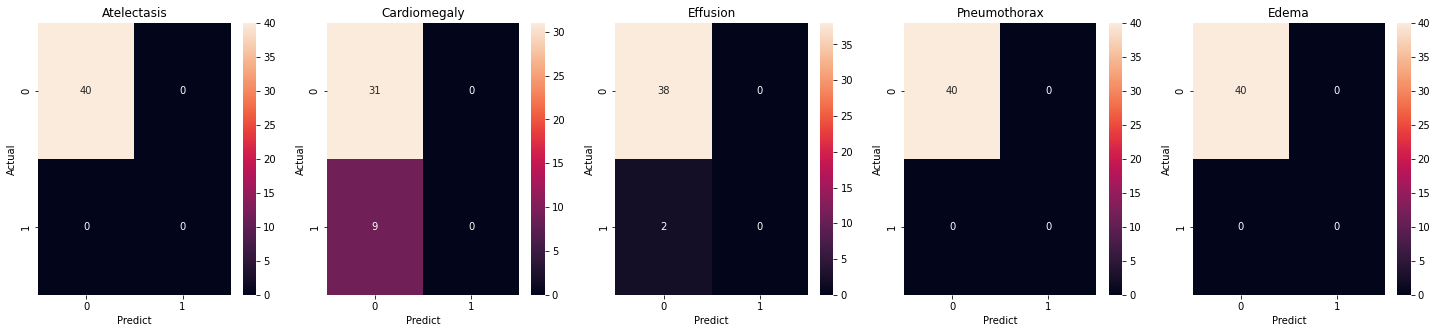

In [72]:
fig, ax = plt.subplots(1,5,figsize=(25,5))
for i in range(n_labels):
    sns.heatmap(multilabel_confusion_matrix(y_test==1,y_pred>=0.5)[i], annot=True, fmt='g', ax=ax[i])
    ax[i].set_title(labels_col[i])
    ax[i].set_xlabel("Predict")
    ax[i].set_ylabel("Actual")